# ARGO DATA in mediterranean see

In [1]:
import xarray as xr
# xr.set_options(display_style='text')
import numpy as np
import pandas as pd

import argopy
# not at home
# argopy.set_options(cachedir='/home1/homedir5/perso/agarciaj/.cache/argopy',src='localftp',local_ftp='/home/ref-argo/gdac')
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()
# argo_loader = ArgoDataFetcher(cache=True)
# trying parallel-requests
#argo_loader = ArgoDataFetcher(src='erddap', parallel=True, chunks={'wmo': 2})

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import seaborn as sns

## Looking for data

In [23]:
# only one year
ds = argo_loader.region([-6, 35, 30, 46, 0, 1000, '2012', '2013']).to_xarray()
#ds

In [3]:
# trying yo use more than one year
#ds1 = argo_loader.region([30, 46, -6, 35, 0, 1000, '2011', '2012']).to_xarray()
#ds2 = argo_loader.region([30, 46, -6, 35, 0, 1000, '2012', '2013']).to_xarray()
#ds = xr.concat([ds1,ds2],dim='N_POINTS')
#ds

In [24]:
dsp = ds.argo.point2profile()
#dsp

In [25]:
# interpolation to standard levels
z = np.arange(0.,1000,10.)
#z

In [26]:
dsi = dsp.argo.interp_std_levels(z)
#dsi
# with z = np.arange(0.,200,1.) interpolation is not working

In [28]:
dsi['PRES_INTERPOLATED'] = -dsi.PRES_INTERPOLATED

In [27]:
#dsi

## Applying PCM

### Create PCM

In [29]:
z = np.arange(0.,-1000,-10.)
# only temperature to try temporal representation
# pcm_features = {'temperature': z, 'salinity' : z}
pcm_features = {'temperature': z}
m = pcm(K=8, features=pcm_features)
m

<pcm 'gmm' (K: 8, F: 1)>
Number of class: 8
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit model

In [30]:
# only temperature to try temporal representation
# features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}
features_in_ds = {'temperature': 'TEMP'}
features_zdim='PRES_INTERPOLATED'
m.fit(dsi, features=features_in_ds, dim=features_zdim)
m

<pcm 'gmm' (K: 8, F: 1)>
Number of class: 8
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: -1.777521

### Classify data

In [31]:
m.predict(dsi, features=features_in_ds, dim=features_zdim, inplace=True)
#dsi

<xarray.Dataset>
Dimensions:            (N_PROF: 502, PRES_INTERPOLATED: 100)
Coordinates:
  * N_PROF             (N_PROF) int64 1244 1312 787 1153 ... 507 1311 2184 618
    TIME               (N_PROF) datetime64[ns] 2012-01-01T12:12:30 ... 2012-12-31T21:25:36
    LATITUDE           (N_PROF) float64 33.64 34.22 40.54 ... 34.14 42.99 35.91
    LONGITUDE          (N_PROF) float64 18.56 27.13 4.63 ... 16.31 6.708 -4.465
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) float64 -0.0 -10.0 ... -980.0 -990.0
Data variables:
    CYCLE_NUMBER       (N_PROF) float64 56.0 19.0 71.0 19.0 ... 129.0 14.0 28.0
    DATA_MODE          (N_PROF) object 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    DIRECTION          (N_PROF) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER    (N_PROF) float64 6.901e+06 6.901e+06 ... 6.9e+06
    PRES               (N_PROF, PRES_INTERPOLATED) float32 5.9 10.0 ... 990.0
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 38.169 ... 38.47753
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 18.004 ... 13.07569
    PCM_LABELS         (N_PROF) int64 6 6 1 6 1 3 6 7 6 3 ... 5 5 6 1 5 5 5 1 1
Attributes:
    cdm_altitude_proxy:        pres
    cdm_data_type:             TrajectoryProfile
    cdm_profile_variables:     cycle_number, data_type, format_version, handb...
    cdm_trajectory_variables:  platform_number, project_name, pi_name, platfo...
    Conventions:               Argo-3.1, CF-1.6, COARDS, ACDD-1.3
    creator_email:             support@argo.net
    creator_name:              Argo
    creator_url:               http://www.argo.net/
    Easternmost_Easting:       34.991
    featureType:               TrajectoryProfile
    geospatial_lat_max:        45.4
    geospatial_lat_min:        31.193
    geospatial_lat_units:      degrees_north
    geospatial_lon_max:        34.991
    geospatial_lon_min:        -5.921
    geospatial_lon_units:      degrees_east
    history:                   2020-07-17T07:17:32Z (local files)\n2020-07-17...
    id:                        ArgoFloats
    infoUrl:                   http://www.argo.net/
    institution:               Argo
    keywords:                  adjusted, argo, array, assembly, best, centre,...
    keywords_vocabulary:       GCMD Science Keywords
    license:                   The data may be used and redistributed for fre...
    Northernmost_Northing:     45.4
    references:                http://www.argodatamgt.org/Documentation
    source:                    Argo float
    sourceUrl:                 (local files)
    Southernmost_Northing:     31.193
    standard_name_vocabulary:  CF Standard Name Table v29
    summary:                   Argo float vertical profiles from Coriolis Glo...
    time_coverage_end:         2012-12-31T23:56:00Z
    time_coverage_start:       2012-01-01T00:56:00Z
    title:                     Argo Float Measurements
    user_manual_version:       3.1
    Westernmost_Easting:       -5.921
    DATA_ID:                   ARGO
    DOI:                       http://doi.org/10.17882/42182
    Fetched_from:              http://www.ifremer.fr/erddap
    Fetched_by:                jovyan
    Fetched_date:              2020/07/17
    Fetched_constraints:       phy_[x=-6.00/35.00; y=30.00/46.00; z=0.0/1000....
    Fetched_uri:               http://www.ifremer.fr/erddap/tabledap/ArgoFloa...

In [32]:
m.predict_proba(dsi, features=features_in_ds, dim=features_zdim, inplace=True)
#dsi

<xarray.Dataset>
Dimensions:            (N_PROF: 502, PRES_INTERPOLATED: 100, pcm_class: 8)
Coordinates:
  * N_PROF             (N_PROF) int64 1244 1312 787 1153 ... 507 1311 2184 618
    TIME               (N_PROF) datetime64[ns] 2012-01-01T12:12:30 ... 2012-12-31T21:25:36
    LATITUDE           (N_PROF) float64 33.64 34.22 40.54 ... 34.14 42.99 35.91
    LONGITUDE          (N_PROF) float64 18.56 27.13 4.63 ... 16.31 6.708 -4.465
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) float64 -0.0 -10.0 ... -980.0 -990.0
Dimensions without coordinates: pcm_class
Data variables:
    CYCLE_NUMBER       (N_PROF) float64 56.0 19.0 71.0 19.0 ... 129.0 14.0 28.0
    DATA_MODE          (N_PROF) object 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    DIRECTION          (N_PROF) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER    (N_PROF) float64 6.901e+06 6.901e+06 ... 6.9e+06
    PRES               (N_PROF, PRES_INTERPOLATED) float32 5.9 10.0 ... 990.0
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 38.169 ... 38.47753
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 18.004 ... 13.07569
    PCM_LABELS         (N_PROF) int64 6 6 1 6 1 3 6 7 6 3 ... 5 5 6 1 5 5 5 1 1
    PCM_POST           (pcm_class, N_PROF) float64 1.815e-16 ... 2.36e-64
Attributes:
    cdm_altitude_proxy:        pres
    cdm_data_type:             TrajectoryProfile
    cdm_profile_variables:     cycle_number, data_type, format_version, handb...
    cdm_trajectory_variables:  platform_number, project_name, pi_name, platfo...
    Conventions:               Argo-3.1, CF-1.6, COARDS, ACDD-1.3
    creator_email:             support@argo.net
    creator_name:              Argo
    creator_url:               http://www.argo.net/
    Easternmost_Easting:       34.991
    featureType:               TrajectoryProfile
    geospatial_lat_max:        45.4
    geospatial_lat_min:        31.193
    geospatial_lat_units:      degrees_north
    geospatial_lon_max:        34.991
    geospatial_lon_min:        -5.921
    geospatial_lon_units:      degrees_east
    history:                   2020-07-17T07:17:32Z (local files)\n2020-07-17...
    id:                        ArgoFloats
    infoUrl:                   http://www.argo.net/
    institution:               Argo
    keywords:                  adjusted, argo, array, assembly, best, centre,...
    keywords_vocabulary:       GCMD Science Keywords
    license:                   The data may be used and redistributed for fre...
    Northernmost_Northing:     45.4
    references:                http://www.argodatamgt.org/Documentation
    source:                    Argo float
    sourceUrl:                 (local files)
    Southernmost_Northing:     31.193
    standard_name_vocabulary:  CF Standard Name Table v29
    summary:                   Argo float vertical profiles from Coriolis Glo...
    time_coverage_end:         2012-12-31T23:56:00Z
    time_coverage_start:       2012-01-01T00:56:00Z
    title:                     Argo Float Measurements
    user_manual_version:       3.1
    Westernmost_Easting:       -5.921
    DATA_ID:                   ARGO
    DOI:                       http://doi.org/10.17882/42182
    Fetched_from:              http://www.ifremer.fr/erddap
    Fetched_by:                jovyan
    Fetched_date:              2020/07/17
    Fetched_constraints:       phy_[x=-6.00/35.00; y=30.00/46.00; z=0.0/1000....
    Fetched_uri:               http://www.ifremer.fr/erddap/tabledap/ArgoFloa...

In [33]:
dsi = dsi.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of='TEMP', outname='TEMP' + '_Q', keep_attrs=True, inplace=True)
# dsi = dsi.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of='PSAL', outname='PSAL' + '_Q', keep_attrs=True, inplace=True)
#dsi

## Visualisation

Vertical structure of classes

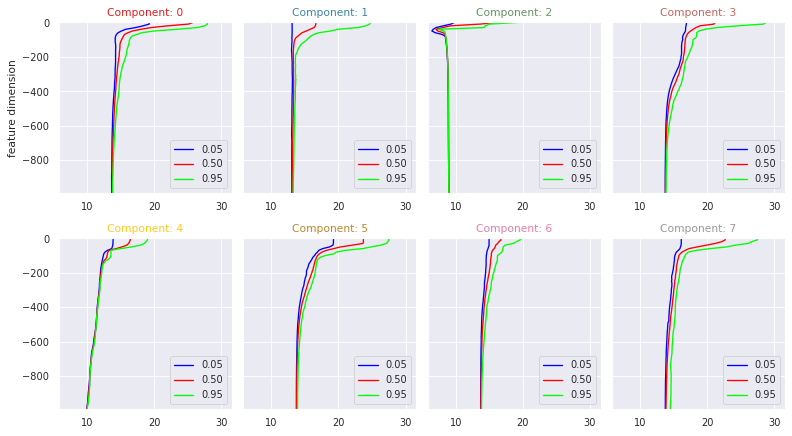

In [34]:
fig, ax = m.plot.quantile(dsi['TEMP_Q'], maxcols=4, figsize=(10, 8), sharey=True)

In [15]:
# fig, ax = m.plot.quantile(dsi['PSAL_Q'], maxcols=4, figsize=(10, 8), sharey=True)

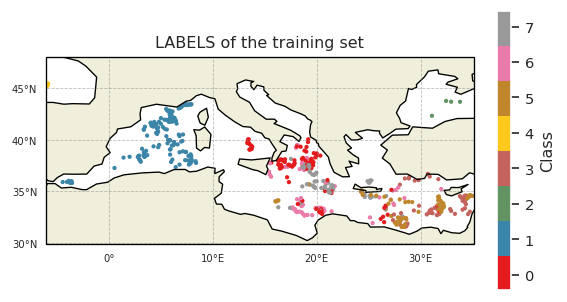

In [35]:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-6,35,30,46]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

kmap = m.plot.cmap()
sc = ax.scatter(dsi['LONGITUDE'], dsi['LATITUDE'], s=3, c=dsi['PCM_LABELS'], cmap=kmap, transform=proj, vmin=0, vmax=m.K)
cl = m.plot.colorbar(ax=ax)

gl = m.plot.latlongrid(ax, dx=10)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('LABELS of the training set')
# saving figure
plt.savefig('ArgoMed_map_labels_EX.png')
plt.show()

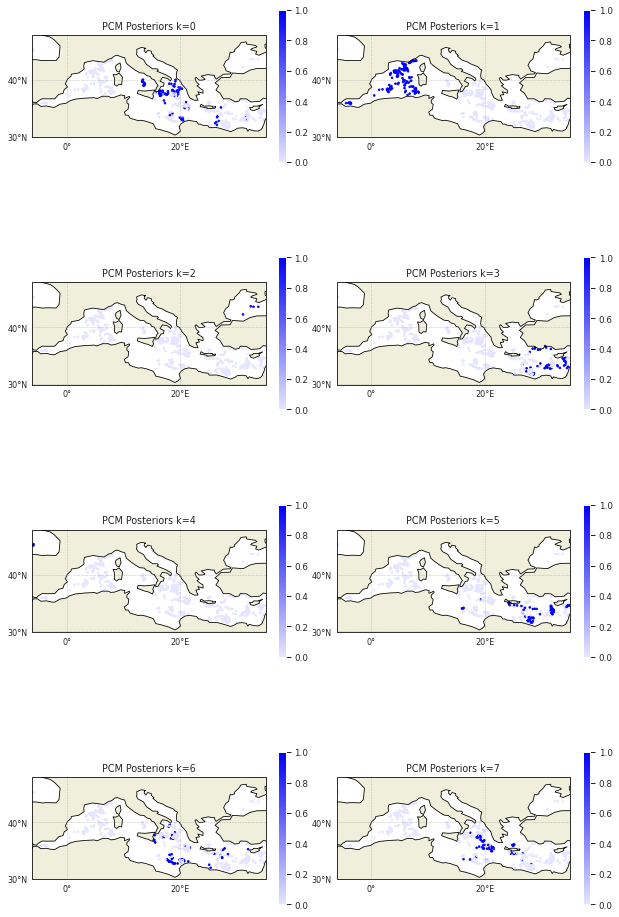

In [36]:
cmap = sns.light_palette("blue", as_cmap=True)
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-6,35,30,46]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = m.plot.subplots(figsize=(10,22), maxcols=2, subplot_kw=subplot_kw)

for k in m:
    sc = ax[k].scatter(dsi['LONGITUDE'], dsi['LATITUDE'], s=3, c=dsi['PCM_POST'].sel(pcm_class=k),
                       cmap=cmap, transform=proj, vmin=0, vmax=1)
    cl = plt.colorbar(sc, ax=ax[k], fraction=0.03)
    gl = m.plot.latlongrid(ax[k], fontsize=8, dx=20, dy=10)
    ax[k].add_feature(cfeature.LAND)
    ax[k].add_feature(cfeature.COASTLINE)
    ax[k].set_title('PCM Posteriors k=%i' % k)
    
plt.savefig('ArgoMed_posteriors_EX.png')

temporal representation

In [37]:
# data to be plot
pcm_labels = dsi['PCM_LABELS']
#pcm_labels

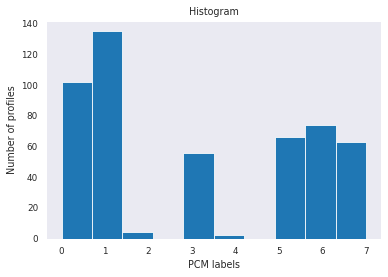

In [38]:
fig, axes = plt.subplots()
pcm_labels.plot.hist()
# y axis is number of profiles
axes.set_ylabel('Number of profiles')
plt.show()

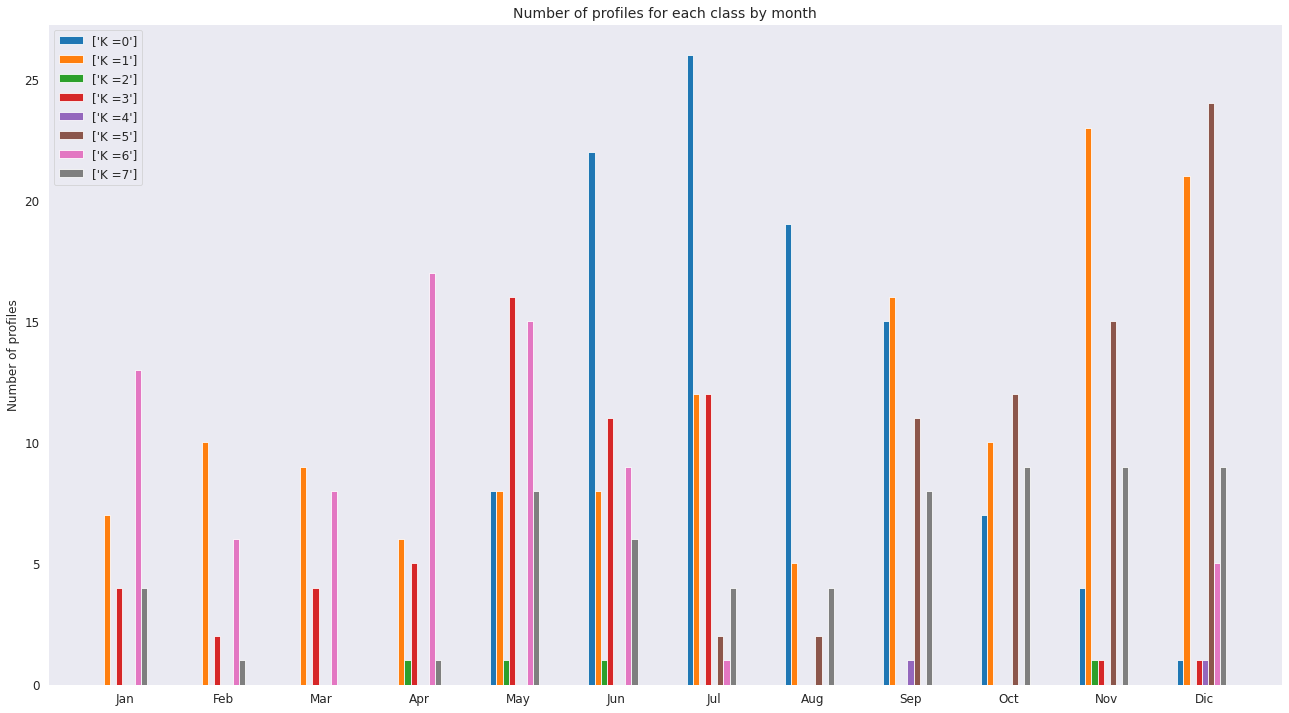

In [39]:
# bar plot in time

#prepare plot
months_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dic']
width = 0.5/(m.K)  # the width of the bars
fig, ax = plt.subplots(figsize=(18,10))

#loop in k and counting in months
for cl in range(m.K):
    #print(cl)
    #get time array with k[i]
    pcm_labels_k = pcm_labels[pcm_labels == cl]
    # count for each month
    counts_k = pcm_labels_k.groupby("TIME.month").count()
    #print(counts_k)
    #plot
    bar_plot_k = ax.bar(counts_k.month - (m.K/2-cl)*width, counts_k, width, label = ['K =' + str(cl)])
    

ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months_labels, fontsize=12)
plt.yticks(fontsize=12)
ax.legend(fontsize=12)
ax.set_ylabel('Number of profiles',fontsize=12)
ax.set_title('Number of profiles for each class by month', fontsize=14)
fig.tight_layout()

# saving figure
plt.savefig('ArgoMed_months_hist_EX.png')

plt.show()

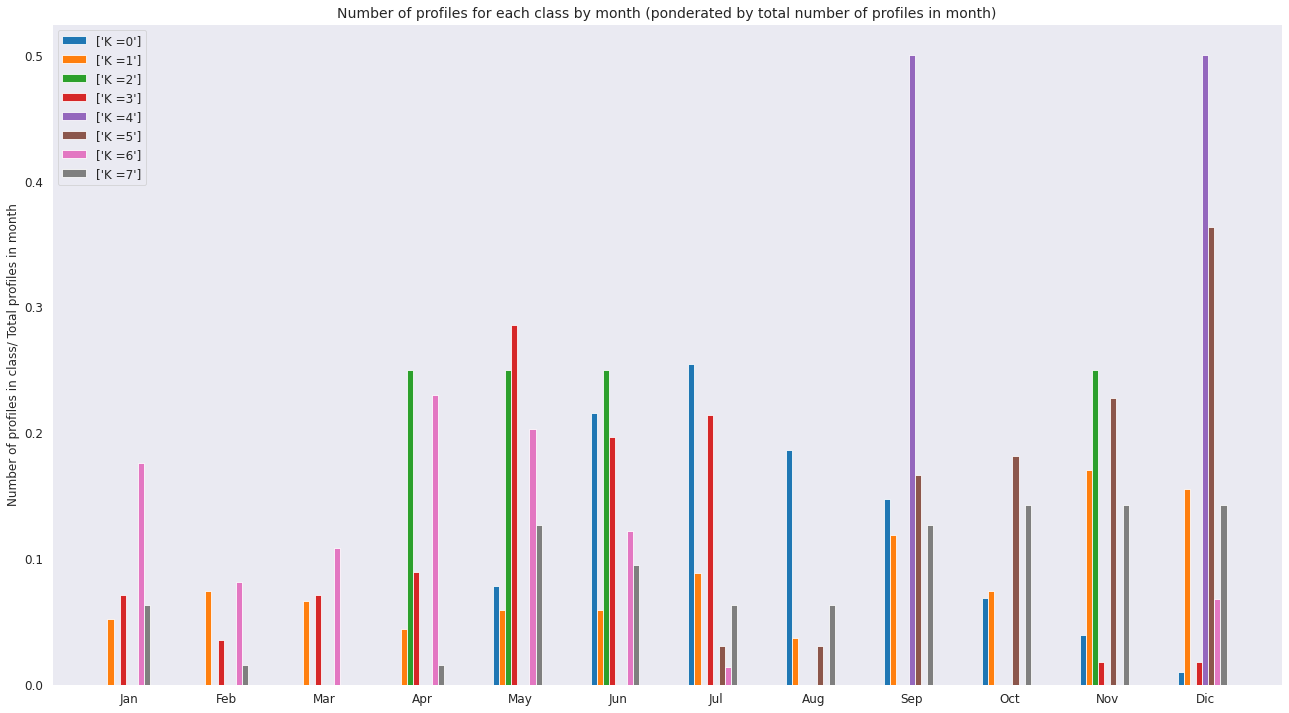

In [40]:
# bar plot in time (relative to the number of measurements per month)

# prepare plot
months_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dic']
width = 0.5/(m.K)  # the width of the bars
fig, ax = plt.subplots(figsize=(18,10))

#loop in k and counting in months
for cl in range(m.K):
    #print(cl)
    #get time array with k[i]
    pcm_labels_k = pcm_labels[pcm_labels == cl]
    # count for each month
    counts_k = pcm_labels_k.groupby("TIME.month").count()
    counts_rel = counts_k/sum(counts_k)
    #print(counts_k)
    #plot
    bar_plot_k = ax.bar(counts_k.month - (m.K/2-cl)*width, counts_rel, width, label = ['K =' + str(cl)])
    #it is not very beautiful
    #plot_k = ax.plot(counts_k.month - (m.K/2-cl)*width, counts_rel)
    

ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months_labels, fontsize=12)
plt.yticks(fontsize=12)
ax.legend(fontsize=12)
ax.set_ylabel('Number of profiles in class/ Total profiles in month',fontsize=12)
ax.set_title('Number of profiles for each class by month (ponderated by total number of profiles in month)', fontsize=14)
fig.tight_layout()

# saving figure
#plt.savefig('ArgoMed_months_hist_rel_EX.png')

plt.show()

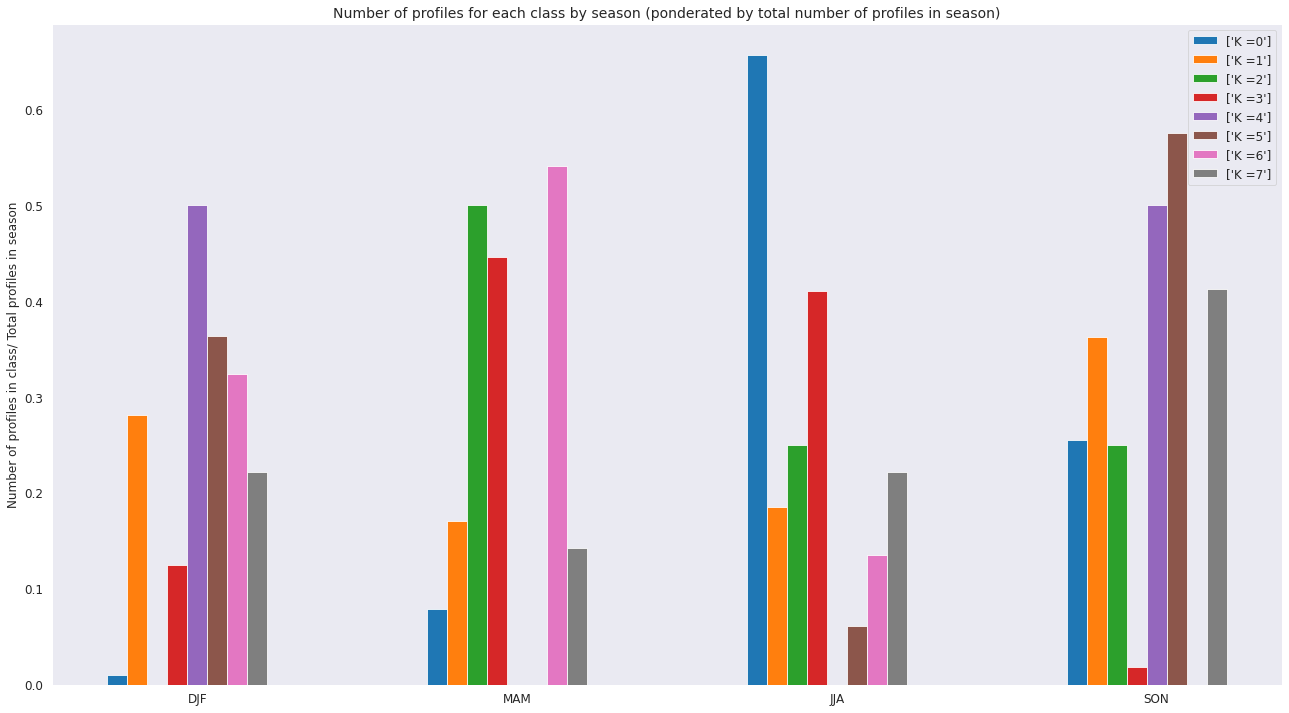

In [41]:
# seasonal bar plot

# prepare plot
seasons_dict = {1: 'DJF', 2: 'MAM', 3: 'JJA', 4:'SON'} 
width = 0.5/(m.K)  # the width of the bars
fig, ax = plt.subplots(figsize=(18,10))


#loop in k and counting in seasons
for cl in range(m.K):
    #print(cl)
    #get time array with k
    pcm_labels_k = pcm_labels[pcm_labels == cl]
    # count for each month
    counts_k = pcm_labels_k.groupby("TIME.season").count()
    counts_rel = counts_k/sum(counts_k)
    #x axis
    x_ticks_k = []
    for i in range(len(counts_k.season)):
        x_ticks_k.append(list(seasons_dict.values()).index(counts_k.season[i]))
        #print(x_ticks_k)
        
    #plot
    bar_plot_k = ax.bar(np.array(x_ticks_k) - (m.K/2-cl)*width, counts_rel, width, label = ['K =' + str(cl)])
    

ax.set_xticks(np.arange(0,4))
ax.set_xticklabels(seasons_dict.values(), fontsize=12)
plt.yticks(fontsize=12)
ax.legend(fontsize=12)
ax.set_ylabel('Number of profiles in class/ Total profiles in season',fontsize=12)
ax.set_title('Number of profiles for each class by season (ponderated by total number of profiles in season)', fontsize=14)
fig.tight_layout()

# saving figure
plt.savefig('ArgoMed_seasons_hist_rel_EX.png')

plt.show()